# PORTFOLIO OPTIMIZATION

## CONVEX OPTIMIZATION

Convex optimization is a subfield of optimization focused on minimizing (or maximizing) convex functions over convex sets. It’s powerful because convex problems have strong theoretical properties: any local minimum is also a global minimum, and they can often be solved efficiently, even for large-scale problems. 

A function $f(x)$ is convex if the line segment between any two points on its graph lies above or on the graph. Formally:
$$f(\lambda x + (1 - \lambda)y) \leq \lambda f(x) + (1 - \lambda)f(y) \quad \forall \lambda \in [0, 1]$$

Convex opt problem:

$$\begin{aligned}
& \min_x \quad f(x) \\
& \text{s.t.} \quad g_i(x) \leq 0, \quad i = 1, …, m \\
& \phantom{\text{s.t.}} \quad h_j(x) = 0, \quad j = 1, …, p
\end{aligned}$$

In portfolio optimization, the goal is to allocate weights w_i to assets in order to:
- Minimize risk (e.g., variance of returns)
- Maximize return (or risk-adjusted return like the Sharpe ratio)
- Subject to constraints (e.g., sum of weights = 1, no short-selling, etc.)


**Markowitz model:**

Minimize portfolio variance for a given expected return:
$$\begin{aligned}
& \min_w \quad w^T \Sigma w \\
& \text{s.t.} \quad \mu^T w \geq r_{\text{target}} \\
& \phantom{\text{s.t.}} \quad \sum w_i = 1 \\
& \phantom{\text{s.t.}} \quad w_i \geq 0 \text{ (no short-selling, optional)}
\end{aligned}$$

## CAPM vs MPT

CAPM extends Markowitz’s Modern Portfolio Theory by introducing an equilibrium model where asset prices depend solely on systematic risk (beta) rather than total risk, assuming a **single optimal market portfolio**, risk-free borrowing, and homogeneous investor expectations, whereas MPT focuses on constructing diversified portfolios along the efficient frontier based on mean-variance optimization without specifying how assets should be priced in the market.

Key Features of MPT:

•	Investors select portfolios based on mean (expected return) and variance (risk).

•	The Efficient Frontier represents portfolios that provide the best risk-return trade-off.

•	The optimal portfolio depends on investor preferences (risk aversion).

•	MPT does not specify a single “best” portfolio but offers a set of efficient ones.

Key features of CAPM:

•	The model quantifies the relationship between an asset’s expected return and its systematic risk, measured by beta β(>1 means high volatility) rather than total risk.

•	It defines the SML, which shows the expected return of an asset as a function of its beta, helping identify underpriced and overpriced assets.

•	Investors can borrow and lend unlimited amounts at the risk-free rate to adjust their portfolio’s risk-return profile. They also have the same expectations about risk.

•	The expected return of an asset is given by the CAPM formula: $E(R_i) = R_f + \beta_i (E(R_m) - R_f)$


Here we'll use MPT, and we'll also consider only ETFs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pypfopt
from scipy.optimize import minimize

In [ ]:
tickers = ['SPY', 'VOO', 'VTI', 'DIA']

"tickers = [\n    'AAPL','MSFT','AMZN','GOOGL','META','NVDA','TSLA','INTC','AMD','QCOM', 'SPY',\n    'ORCL','IBM','CSCO','TXN','AVGO','CRM','SAP', 'BRK-B',\n    'NFLX','DIS','CMCSA',\n    'VZ','T',\n    'KO','PEP','PG','UL',\n    'WMT','COST','HD','LOW',\n    'NKE','SBUX','MCD','YUM',\n    'JNJ','PFE','MRK','GILD','AMGN','LLY','ABBV','UNH','CVS',\n    'XOM','CVX','COP','SLB','EOG',\n    'JPM','BAC'\n]"

In [15]:
data = yf.download(tickers, start="2015-01-01", end="2025-01-01", auto_adjust=False)["Adj Close"]

data.head()

[*********************100%***********************]  4 of 4 completed

4 Failed downloads:
['VOO', 'SPY', 'DIA', 'VTI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Ticker,DIA,SPY,VOO,VTI
Date,,,,


In [ ]:
treasury_yield = yf.Ticker("^TNX")
treasury_data = treasury_yield.history(start="2015-01-01", end="2025-01-01")
risk_free_rate = treasury_data['Close'].iloc[-1] / 100

print(f"Risk-Free Rate: {risk_free_rate:.2%}")

## Data exploration

**Prices**

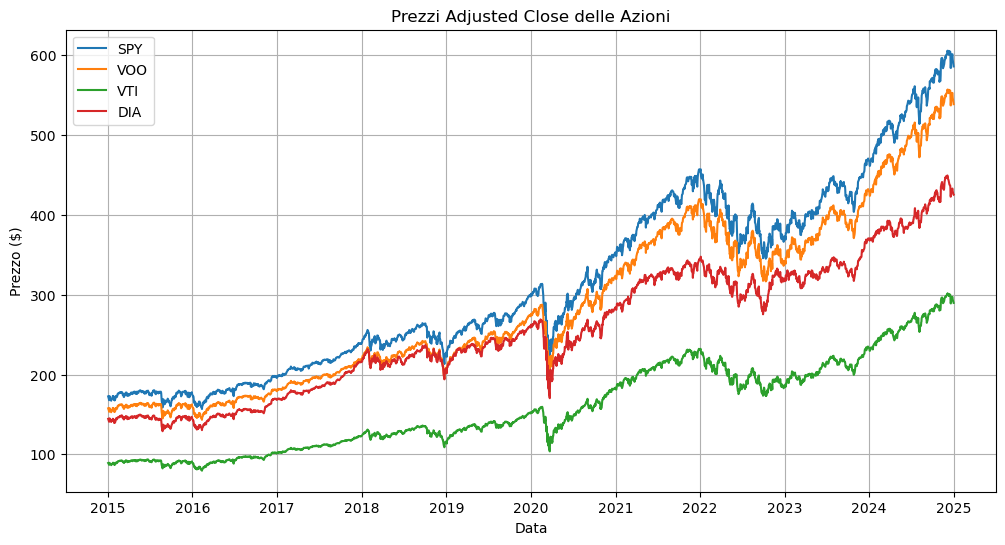

In [ ]:
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)

plt.title("Adj Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid()
plt.show()

**Daily returns distribution**

In [ ]:
returns = data.pct_change().dropna()

# log returns
#returns = np.log(data / data.shift(1))
#returns = returns.dropna()

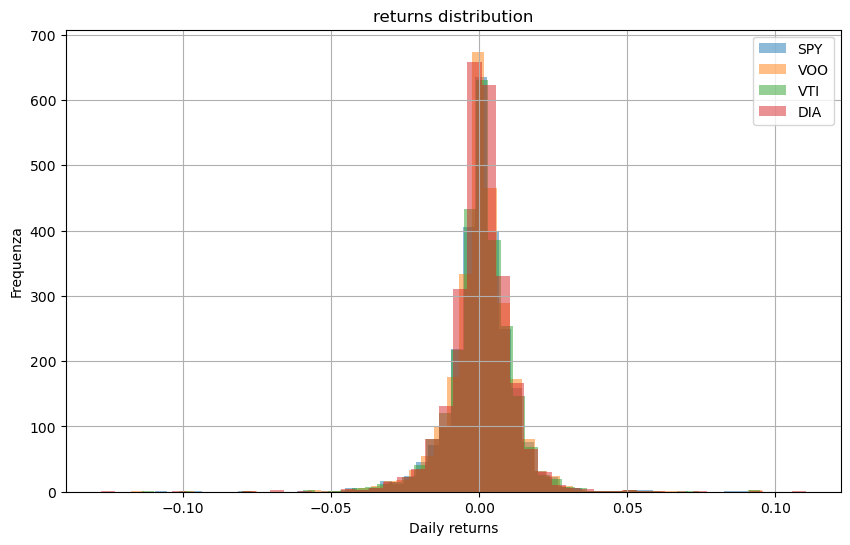

Ticker,DIA,SPY,VOO,VTI
Date,,,,
2015-01-05,-0.017422,-0.018059,-0.017569,-0.017183
2015-01-06,-0.008293,-0.009419,-0.009833,-0.009798
2015-01-07,0.012688,0.012461,0.012495,0.011933
2015-01-08,0.018054,0.017745,0.017569,0.017640
2015-01-09,-0.008615,-0.008013,-0.008421,-0.008290


In [ ]:
plt.figure(figsize=(10, 6))

for ticker in tickers:
    plt.hist(returns[ticker], bins=50, alpha=0.5, label=ticker)

plt.title("returns distribution")
plt.xlabel("Daily returns")
plt.ylabel("Frequenza")
plt.legend()
plt.grid()
plt.show()

returns.head()

**Covariance:**

In [ ]:
cov_matrix = returns.cov() * 252 # Annualizzati
print(cov_matrix)

Ticker       DIA       SPY       VOO       VTI
Ticker                                        
DIA     0.030475  0.029331  0.029678  0.029810
SPY     0.029331  0.031044  0.031340  0.031562
VOO     0.029678  0.031340  0.031692  0.031878
VTI     0.029810  0.031562  0.031878  0.032355


## Permormance Measures

In [ ]:
'''Standard Deviation'''
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

The STD defines the volatility of the portfolio.

In [ ]:
'''Expected Return (general performance)'''
def expected_return(weights, returns):
    return np.sum(returns.mean() * weights) * 252

In [ ]:
'''Sharpe ratio'''
def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

# We want to minimize the neg sharpe ratio
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)

The sharpe ratio is used to evaluate the risk-adjusted return of an investment or portfolio. It represents the ratio between the excess return over the risk-free rate and volatility, i.e. it is a measure of the risk/return ratio. It helps determine whether the returns are due to smart investment decisions or excessive risk.


•	Higher Sharpe Ratio → Better risk-adjusted performance.

•	Sharpe Ratio > 1 → Good return for the level of risk taken.

•	Sharpe Ratio < 1 → Returns are not sufficiently high for the risk taken.

•	Sharpe Ratio < 0 → Worse performance than a risk-free asset.



$$
\text{S.R.} = \frac{r_p - r_f}{\sigma_p}
$$

•	 $r_p$  = Portfolio return

•	 $r_f$  = Risk-free rate (e.g., U.S. Treasury bond yield)

•	 $\sigma_p$  = Standard deviation of portfolio returns (risk)

In [ ]:
'''CVaR'''

def portfolio_CVaR(weights, returns, alpha=0.95):
    port_returns = returns.dot(weights)
    sorted_returns = np.sort(port_returns)
    num_samples = len(sorted_returns)
    cvar_index = int((1 - alpha) * num_samples)
    cvar_index = max(cvar_index, 1)  
   
    CVaR = -np.mean(sorted_returns[:cvar_index])
    return CVaR

The Conditional Value at Risk provides a more comprehensive assessment of potential losses beyond the VaR threshold. It considers the average loss given that the loss exceeds the VaR level, making it a valuable tool for risk management and decision-making. It's basically the average value of the worst losses (1-alpha%).
CVaR takes into account the severity of extreme outcomes and provides insights into tail risk. By incorporating both the probability and magnitude of losses, CVaR offers a robust and informative measure for quantifying and managing risk.

$$\text{CVaR} = \frac{1}{1-\alpha} \int_{1}^{Var} xp(x)dx$$

Now we add a penalty to the Sharpe ratio based on the CVaR:

In [ ]:
def objective_function(weights, returns, cov_matrix, risk_free_rate, lambda_cvar, alpha=0.95):
    neg_sharpe = neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)
    
    port_returns = returns.dot(weights)
    sorted_returns = np.sort(port_returns)
    num_samples = len(sorted_returns)
    cvar_index = int((1 - alpha) * num_samples)
    cvar_index = max(cvar_index, 1)
    cvar_value = np.mean(sorted_returns[:cvar_index])
   
    objective = neg_sharpe + lambda_cvar * (-cvar_value)
    
    return objective


## Portfolio optimization

We now define constraints and bounds. The limit, in our case, is that the sum of the weights must equal 1. \
The constraints variable is a dictionary with two keys: ‘type’, set to ‘equality constraint’ (eq) and ‘fun’, assigned to the function that controls the sum of the weights. \
Bound are 0 and 0.5

In [ ]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0, 1) for _ in range(len(tickers))]


Now we set the initial weights, to then optimize them in order to maximize the Sharpe ratio.

In [ ]:
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.25 0.25 0.25 0.25]


In [ ]:
lambda_cvar = 1

In [ ]:
optimize_result = minimize(
    objective_function, 
    initial_weights, 
    args=(returns, cov_matrix, risk_free_rate, lambda_cvar), 
    method= 'SLSQP', 
    constraints=constraints, 
    bounds=bounds
)


optimal_weights = optimize_result.x

SLSQP stands for Sequential Least Squares Quadratic Programming, which is an optimisation technique used in non-linear problems. We now obtain the optimal weights.

In [ ]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
SPY: 0.0000
VOO: 0.4994
VTI: 0.5006
DIA: 0.0000


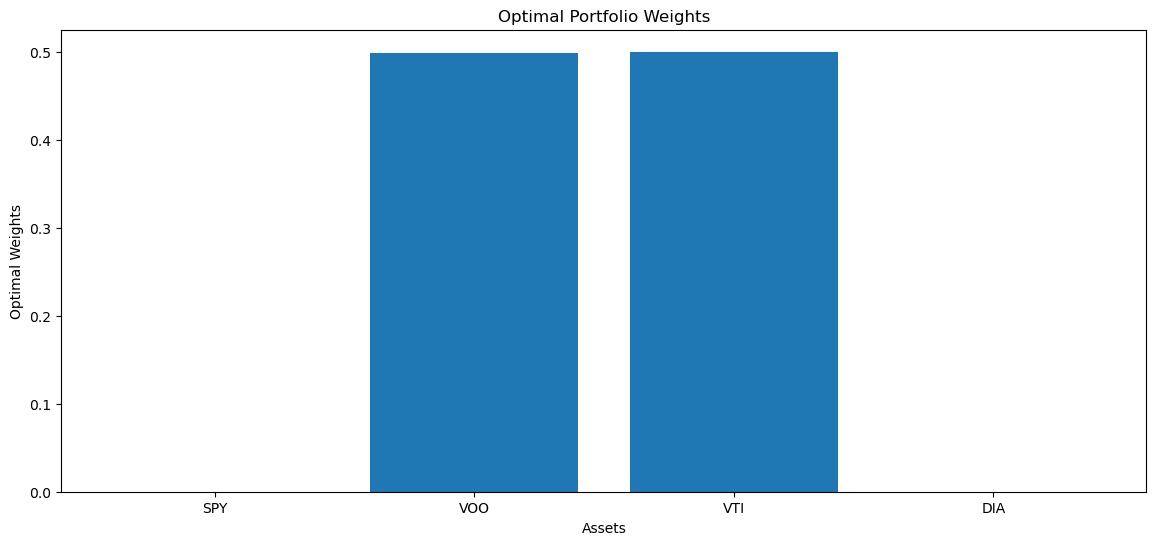

In [ ]:
plt.figure(figsize=(14, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

## Analize the optimal portfolio

In [ ]:
optimal_portfolio_return = expected_return(optimal_weights, returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe = sharpe_ratio(optimal_weights, returns, cov_matrix, risk_free_rate)
optimal_CVaR = portfolio_CVaR(optimal_weights, returns, alpha=0.95)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe:.4f}")
print(f"CVaR: {optimal_CVaR:.4f}")

Expected Annual Return: 0.1386
Expected Volatility: 0.1771
Sharpe Ratio: 0.5245
CVaR: 0.0273


This MC simulation randomly generates portfolios, calculates their annualized return and volatility (STD).

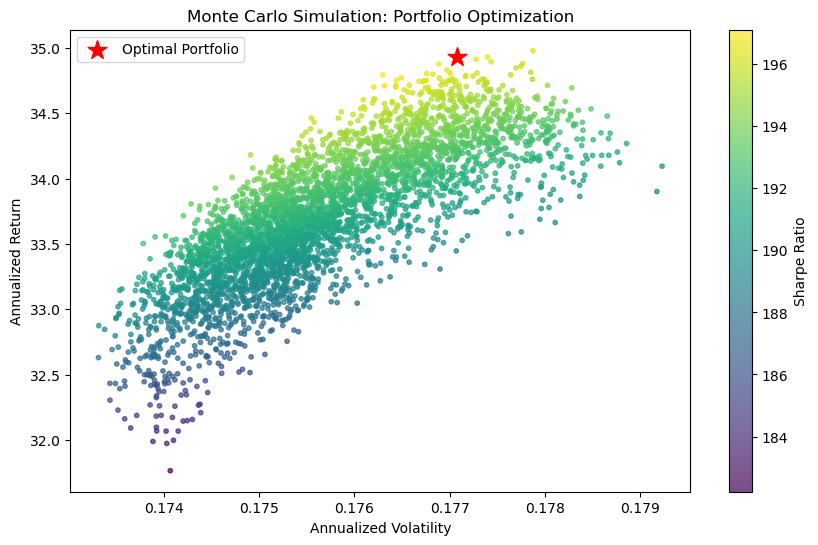

In [ ]:
# Monte Carlo simulation
num_portfolios = 4000
results = np.zeros((3, num_portfolios))
all_weights = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    all_weights.append(weights)
    
    # Calculate annualized portfolio return and volatility
    port_return = expected_return(weights, returns) * 252  # annualized return
    port_volatility = standard_deviation(weights, cov_matrix)  # annualized volatility
    sharpe = (port_return - risk_free_rate) / port_volatility  # Sharpe ratio
    
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe

plt.figure(figsize=(10, 6))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.7)
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Monte Carlo Simulation: Portfolio Optimization")
cbar = plt.colorbar(scatter)
cbar.set_label("Sharpe Ratio")

# Overlay the optimal solution:
plt.scatter(optimal_portfolio_volatility, optimal_portfolio_return * 252, color='red', marker='*', s=200, label='Optimal Portfolio')
plt.legend()

plt.show()